# Steganalysis ROC/AUC Curves

This document contains some tools to generate ROC/AUC curves, and then generates several curves for our suite of Steganalysis tools, on a sample encoded image bank.

## Set-up

### Drive Mount

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Modules

In [1]:
!pip install scikit-plot 

### SteganoGAN

In [2]:
!git clone https://github.com/jnickg/steganet

Cloning into 'steganet'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 12), reused 18 (delta 4), pack-reused 0
Unpacking objects: 100% (41/41), done.


### Alethia

In [3]:
!git clone https://github.com/daniellerch/aletheia.git
!sudo apt-get -qq install octave octave-image octave-signal
!sudo apt-get -qq update
!sudo apt-get -qq install liboctave-dev imagemagick
!pip install -r aletheia/requirements.txt
!pip install efficientnet

Cloning into 'aletheia'...
remote: Enumerating objects: 1884, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 1884 (delta 123), reused 185 (delta 41), pack-reused 1603
Receiving objects: 100% (1884/1884), 977.68 MiB | 34.30 MiB/s, done.
Resolving deltas: 100% (1107/1107), done.
Checking out files: 100% (315/315), done.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 107.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package install-info.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../instal

### StegExpose

In [4]:
# Install the Java JDK.
!apt-get install default-jdk > /dev/null

# Check the Java version to see if everything is working well.
!javac -version

!git clone https://github.com/b3dk7/StegExpose

javac 11.0.11
Cloning into 'StegExpose'...
remote: Enumerating objects: 314, done.
remote: Total 314 (delta 0), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (314/314), 38.31 MiB | 36.84 MiB/s, done.
Resolving deltas: 100% (133/133), done.


## Statistical Steganalysis

We use `StegExpose` to evaluate our encoded images using a suite of statistical attacks.

Save the results to `stegexpose_analysis`, so we can later extract results from the many tools it encompasses.

Specifically, we'll look at:
* Chi Square Attack (Westfeld, 1999)
* RS Analysis (Fridrich, 2001)
* Primary Sets (Dumitrescu, 2002)

### Sample

In [6]:
!java -jar ./StegExpose/StegExpose.jar /content/steganet/assets/test_images/ default default steg_expose.csv
!awk '!/^$/' steg_expose.csv > steg_expose_clean.csv
stegexpose_results_file = 'steg_expose_clean.csv'

#### Overall Results

In [7]:
from prettytable import from_csv

with open(stegexpose_results_file) as fp:
  stegexpose_analysis = from_csv(fp)
  print(stegexpose_analysis)

+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
|    File name     | Above stego threshold? | Secret message size in bytes (ignore for clean files) |      Primary Sets     |      Chi Square      |     Sample Pairs    |     RS analysis      |     Fusion (mean)     |
+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
|  input (1).png   |         false          |                         27014                         | 0.0027757271722806953 | 8.820295629479369E-4 | 0.00931381861772712 | 0.009866536838759855 | 0.0057095280479289015 |
| Dense_output.png |         false          |                         404960                        |          NaN          | 0.

#### Loading to Memory

Rather than just dumping the data to a pretty table, let's now load it into a 2-D "tensor" of results, where the first axis is the input file name, and the second axis is the attack vector. Elements are $[0.0,1.0]$ probabilities based on that attack.

In [23]:
import csv
import numpy as np

# Takes a function that returns either 1 or 0 based on the filename
def stegexpose_file_to_data(filename, file_ck_fn=None):
  with open(filename) as fp:
    results = []
    files = []
    actuals = []
    reader = csv.reader(fp)
    next(reader) # skip header
    for row in reader:
      if len(row) > 0:
        files.append(row[0])
        results.append(row[3:])
        label = 1 # assume it was encoded unless it's an input image
        if file_ck_fn is not None:
          label = file_ck_fn(row[0])
        actuals.append(label)
  files = np.array(files)
  results = np.array(results)
  actuals = np.array(actuals)
  return files, actuals, results

In [28]:
def sample_file_ck_fn(name):
  if 'input' in name:
    return 0
  else:
    return 1

stegexpose_files, stegexpose_actuals, stegexpose_results = stegexpose_file_to_data(stegexpose_results_file, file_ck_fn=sample_file_ck_fn)

In [29]:
print(stegexpose_files)

['input (1).png' 'Dense_output.png' 'Basic_output.png']


In [30]:
print(stegexpose_results)

[['0.0027757271722806953' '8.820295629479369E-4' '0.00931381861772712'
  '0.009866536838759855' '0.0057095280479289015']
 ['NaN' '0.002974292221644861' '0.07730278219798781'
  '0.07567560042732396' '0.051984224948985545']
 ['0.02950287639129132' '0.009233439993378239' '0.03330575897854599'
  '0.029716130698238086' '0.02543955151536341']]


In [31]:
print(stegexpose_actuals)

[0 1 1]


#### Extracting a single set of results

These values represent probabilities based on the given attack, that 

In [12]:
primary_sets_idx = 0
chi_square_idx = 1
sample_pairs_idx = 2
rs_analysis_idx = 3
fusion_idx = 4

In [109]:
def extract_column(csv_data, idx):
  results = np.array([float(r) if 'null' not in r else float(0) for r in csv_data[:,idx] ])
  results = np.nan_to_num(results)
  # print(f'Extracted column {idx}: {results}')
  return results

In [73]:
chi_square_results = extract_column(stegexpose_results, chi_square_idx)
print(chi_square_results)

Extracted column 1: [0.00088203 0.00297429 0.00923344]
[0.00088203 0.00297429 0.00923344]


#### ROC Curves

Based on the results of our statistical steganalysis, which contains probability values, we now increase our threshold and plot ROC data.

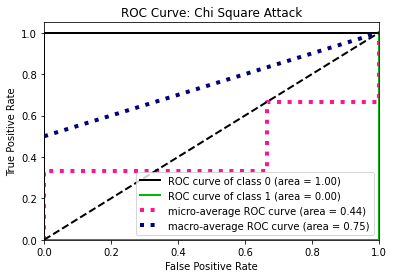

In [103]:
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

def print_roc_for(actual_labels, predictions, name):
  # print(f'print_roc_for(\'{actual_labels}\', \'{predictions}\', \'{name}\'')
  probs = np.reshape(np.concatenate((1.0-predictions,predictions)), (-1, 2))
  # print(f'Reshaped probabilities: {probs}')
  skplt.metrics.plot_roc(actual_labels, probs)
  plt.title(f'ROC Curve: {name}')
  plt.show()

print_roc_for(stegexpose_actuals, chi_square_results, "Chi Square Attack")

Now that we are able to generate a single ROC curve, let's put it together and generate curves for all of our attack vectors, based on the steganalysis resutls!

In [106]:
indices = [primary_sets_idx, chi_square_idx, sample_pairs_idx, rs_analysis_idx, fusion_idx]
names = ['Primary Sets Attack', 'Chi Square Attack', 'Sample Pairs Attack', ' RS Analysis', 'StegExpose Fusion']

# Expects results to be a 2D array where the first axis is the image that was
# predicted, and the second axis represents the attack vector. Anyone wanting to
# print using this, for a single attack vector, should have a size-one array for
# prediction_indices and prediction_names, and results should be a 2D array with
# a single column (one set of attack-vector results for many different images)
def print_all_rocs(results, actuals, prediction_indices, prediction_names):
  for (name, idx) in zip(names, indices):
    # print(f'Displaying ROC for {name}')
    col = extract_column(results, idx)
    print_roc_for(actuals, col, name)

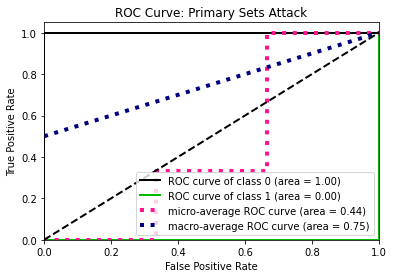

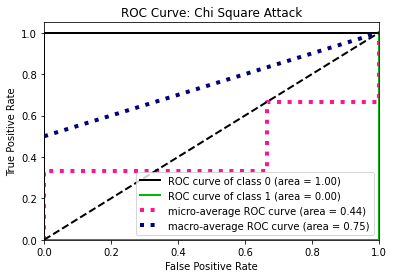

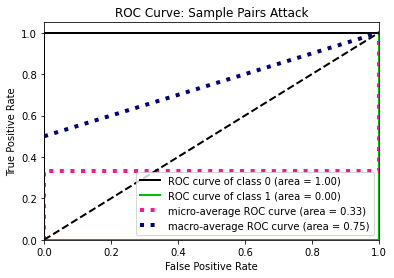

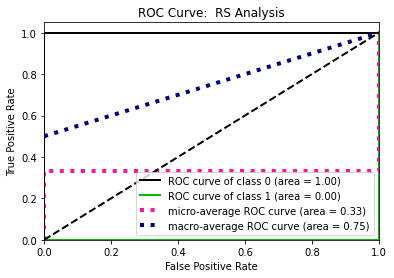

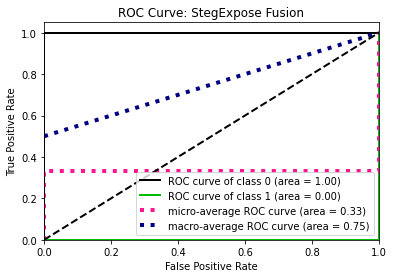

In [107]:
print_all_rocs(stegexpose_results, stegexpose_actuals, indices, names)

### SteganoGAN

In [92]:
basic_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs'
basic_full_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs'
dense_half_path = '/content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs'
input_path = '/content/drive/MyDrive/steganet_images/our_animals'

In [93]:
def steganogan_file_ck(name):
  if 'enc' in name:
    return 1
  else:
    return 0

In [94]:
!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/our_animals default default steganogan_inputs.csv
!awk '!/^$/' steganogan_inputs.csv > steganogan_inputs_clean.csv
stegexpose_steganogan_inputs = 'steganogan_inputs_clean.csv'

stegexpose_steganogan_results = []

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b10_limit_half_hs16_10epochs default default steganogan_basic_half.csv
!awk '!/^$/' steganogan_basic_half.csv > steganogan_basic_half_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_half_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Basic_b4_limitinf_hs32_10epochs default default steganogan_basic_full.csv
!awk '!/^$/' steganogan_basic_full.csv > steganogan_basic_full_clean.csv
stegexpose_steganogan_results.append('steganogan_basic_full_clean.csv')

!java -jar ./StegExpose/StegExpose.jar /content/drive/MyDrive/steganet_images/Encoded_images_Dense_b10_limit_half_hs16_10epochs default default steganogan_dense_half.csv
!awk '!/^$/' steganogan_dense_half.csv > steganogan_dense_half_clean.csv
stegexpose_steganogan_results.append('steganogan_dense_half_clean.csv')

In [95]:
from prettytable import from_csv

for f in stegexpose_steganogan_results:
  print(f'\nStegexpose results: {f}')
  stegexpose_analysis = None
  fp = None
  with open(f) as fp:
    stegexpose_analysis = from_csv(fp)
    print(stegexpose_analysis)


Stegexpose results: steganogan_basic_half_clean.csv
+--------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
| File name,Above stego threshold?,Secret message size in bytes (ignore for clean files),Primary Sets,Chi Square,Sam |                                            le Pairs,RS analysis,Fusion (mean)                                           |
+--------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
|                                                       enc_1.                                                       |  ng,false,448235,0.09856057374479914,2.7994136187012134E-5,0.07705039050227035,0.07500052593661091,0.0626

In [96]:
print(stegexpose_steganogan_inputs)
(files_i, actuals_i, results_i) = stegexpose_file_to_data(stegexpose_steganogan_inputs, file_ck_fn=steganogan_file_ck)

steganogan_stegexpose_data = []
for f in stegexpose_steganogan_results:
  (files, actuals, results) = stegexpose_file_to_data(f, file_ck_fn=steganogan_file_ck)
  steganogan_stegexpose_data.append((files, actuals, results))

steganogan_inputs_clean.csv


In [97]:
print(files_i)
print(actuals_i)
print(results_i)

['INPUT_1.png' 'INPUT_2.png' 'INPUT_3.png' 'INPUT_4.png' 'INPUT_5.png'
 'INPUT_6.png' 'INPUT_7.png' 'INPUT_8.png' 'INPUT_9.png' 'INPUT_10.png'
 'INPUT_11.png']
[0 0 0 0 0 0 0 0 0 0 0]
[['0.008126735573174651' '5.7620711176634713E-5' '0.005924536738879067'
  '0.007714324803872075' '0.005455804456775607']
 ['0.0019954125422904775' '0.006902686879601202' 'null'
  '0.0020172364311082623' '0.003638445284333314']
 ['0.016599869056036085' '5.990974239744222E-4' '0.055815373414820645'
  '0.05204827802670022' '0.03126565448038284']
 ['0.04458418409316608' '5.919164298345019E-4' '0.04436520446330975'
  '0.04374875563752749' '0.03332251515595945']
 ['0.032765784658513035' '2.8628737488687304E-5' '0.01089687832007514'
  '0.012746217668770371' '0.014109377346211807']
 ['0.002875471792710057' '1.4961355723277933E-4' '0.013386571626157593'
  '0.015477447053858229' '0.007972276007489666']
 ['0.006657923694039734' '3.823339015606576E-4' '0.020001675641167855'
  '0.019229653815880286' '0.011567896763162



ROC Curves for steganogan_basic_half_clean.csv


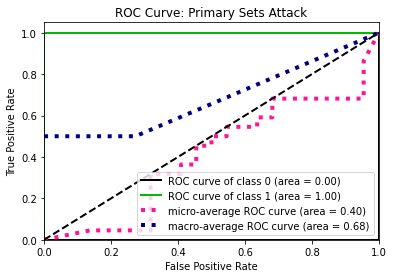

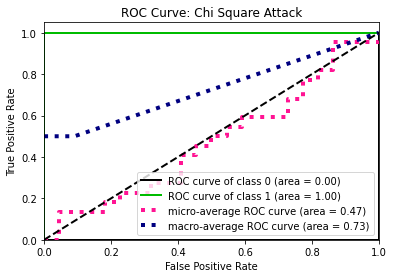

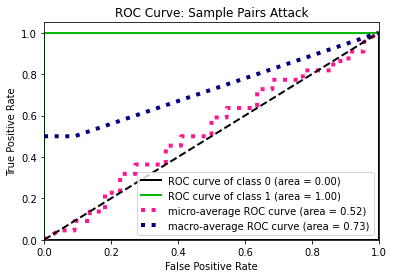

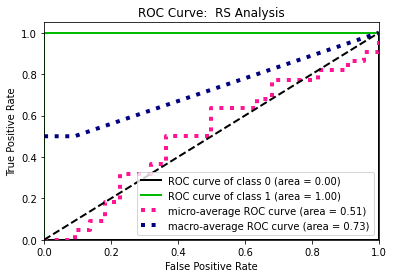

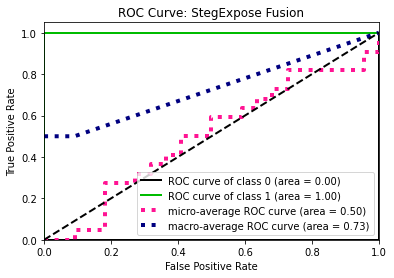



ROC Curves for steganogan_basic_full_clean.csv


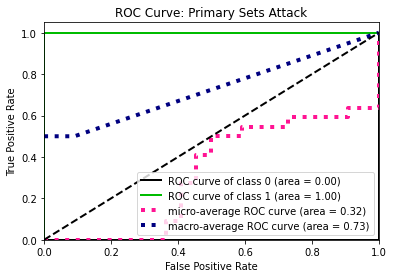

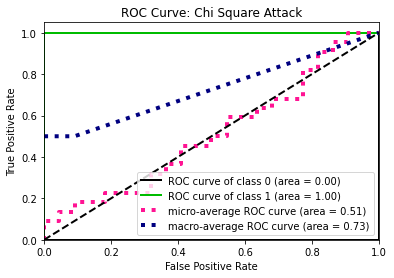

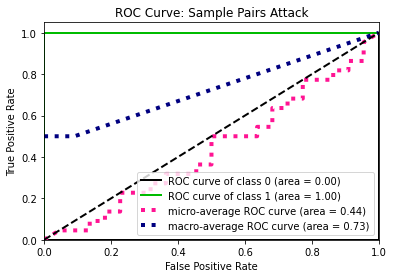

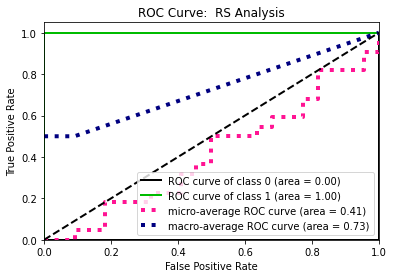

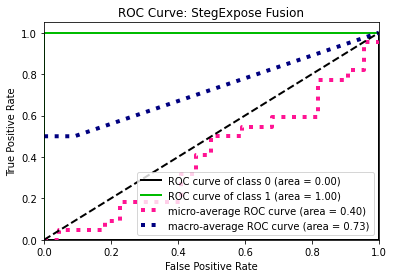



ROC Curves for steganogan_dense_half_clean.csv


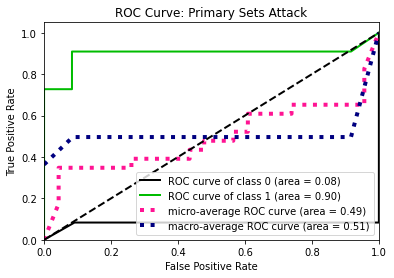

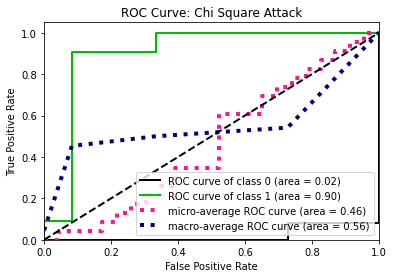

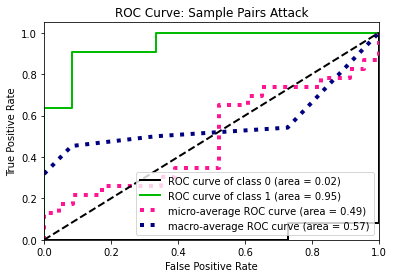

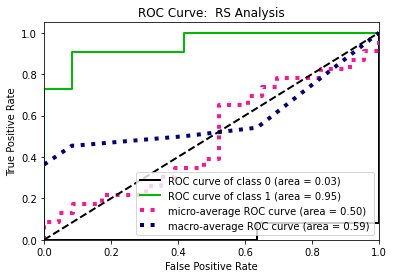

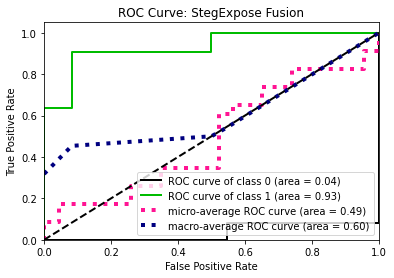

In [111]:
for (fname, (files, actuals, results)) in zip(stegexpose_steganogan_results, steganogan_stegexpose_data):
  files = np.concatenate((files, files_i), axis=0)
  actuals = np.concatenate((actuals, actuals_i))
  results = np.concatenate((results, results_i))
  # print(f'ROC for {fname}')
  # print(f'RESULTS: {results}')
  # print(f'ACTUALS: {actuals}')
  # print(f'INDICES: {indices}')
  # print(f'NAMES: {names}')
  print(f'\n\nROC Curves for {fname}')
  print_all_rocs(results, actuals, indices, names)